# Can We Predict Whether Someone Survived The Titanic Sinking?

The sinking of the Titanic is one the most well known events in human history. Boasting both pop-culture significance and historical relevance there are likely thousands if not millions of people who have asked the question; "Would I survive the Titanic?" While we have no way to go back in time and see for ourselves we thankfully have the second best thing: data. More specifically data on the passengers. We know who they were, where they stayed and most importantly if they survived. Let's take a look at this historical demographic battle royale and see what kind of person was most likely to survive the Titanic.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

Before we start to do any actual analysis it is a good idea to get a grasp on the data we have.

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are 12 categories provided to us. It is a good idea to write down exactly what they each represent.

PassengerId - ID of the Passenger

Pclass - The ticket class the passenger has. The quality goes best to worst 1, 2, 3

Name - The name of the Passenger

Sex - The sex of the passenger Male or Female

Age - The age of the Passenger

SibSp - The number of Siblings or Spouses the Passenger had on board

Parch - The number of Parents or Children the Passenger had on board

Ticket -  The Ticket Number of the Passenger

Fare - The Price paif for the ticket

Cabin - The Cabin they resided in

Embarked - The Port from which they embarked C = Cherbourg, Q = Queenstown, S = Southampton

The Standout Category is Survived

Survived - Whether or not they survived. 1 for Yes, 0 for No.

Our entire model will be built around predicting whether a Passenger gets a 1 or a zero.

Now that we have laid our categories lets explore their relevance try to fit them into our model.

The first order of business is to remove any data that is not directly useful to us. From a cursory exploration of Ticket I have found no pattern or method that ticket can be used to predict odds  of survival so it should be dropped.

In [4]:
train_data = train_data.drop('Ticket', axis = 1)
test_data = test_data.drop('Ticket', axis = 1)

<Axes: xlabel='Pclass', ylabel='Survived'>

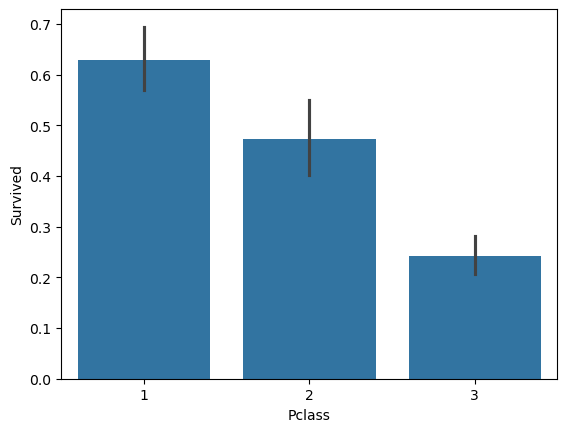

In [5]:
sns.barplot(x="Pclass", y="Survived", data=train_data)

Class has an obvious effect on survival rate as passengers of a higher class have a larger proportion of surviving passengers. The data is alrady broken down into a simpl 1, 2, 3 so no changes are needed.


<Axes: xlabel='Sex', ylabel='Survived'>

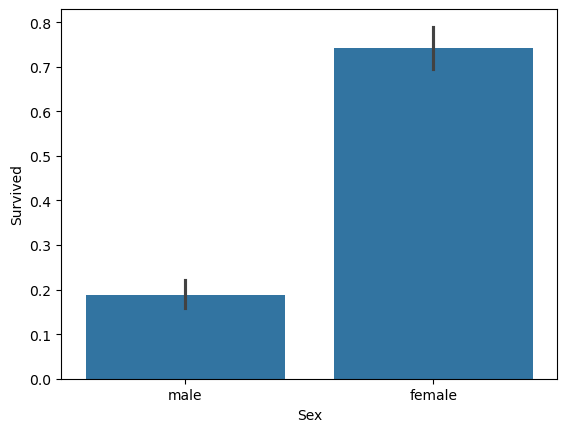

In [6]:
sns.barplot(x="Sex", y="Survived", data=train_data)

Sex has a very clear impact on survival rate as the proportion of 'female' passengers who survived is much higher than 'male' passengers. To make it easier for the model to work with lets change male and female to 0's and 1's.

In [7]:
train_data.loc[train_data["Sex"] == 'male', 'Sex'] = 0
train_data.loc[train_data["Sex"] == 'female', 'Sex'] = 1

test_data.loc[test_data["Sex"] == 'male', 'Sex'] = 0
test_data.loc[test_data["Sex"] == 'female', 'Sex'] = 1

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,S


Embark location has some effect on Survival with Cherbourg having the highest survival rate. We should change the letters to a numeric system.

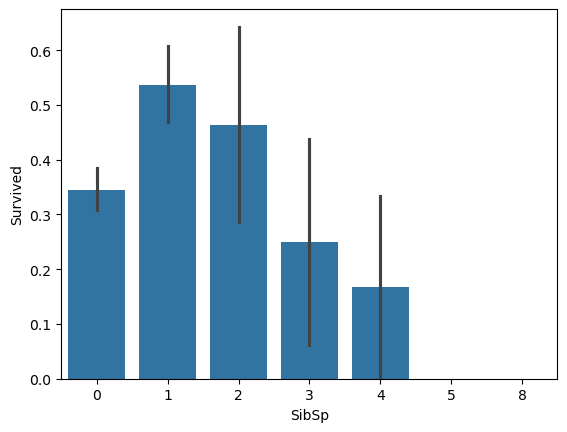

In [8]:
sns.barplot(x="SibSp", y="Survived", data=train_data)
plt.show()


For SibSp the most noticeable impact is that if you have more than 2 Sib/SP you are more likely to die. Aditionally if you have 0 Sib/Sp then you are also more likely to die. The sweetspot seems to be 1 or 2 Sib/SP. SibSp is already a numeric system so no changes are needed.

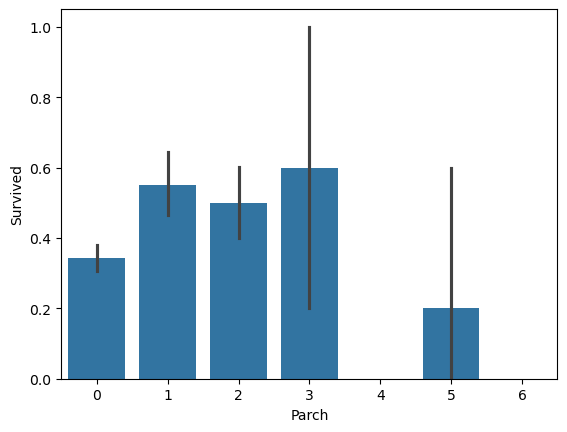

In [9]:
sns.barplot(x="Parch", y="Survived", data=train_data)
plt.show()

For Parch the most noticebale impact is that if you have more than 3 Par/Ch on board you are basically garunteed to die. If you have 0 Par/Ch then you are more likely to die and for 1,2 or 3 Par/Ch you have about a 50/50 or better shot at surviving. Parch is already a numeric system so no changes are needed.

'Name' will require some work before it can be properly graphed. Despite the name 'Name' the primary value in 'Name' is knowing the persons 'Title'. We can determine gender if by titles like Mr., Miss, Mrs., and we can gauge class with titles like Rev. or Dr. Due to the variety of titles we will need to pull from both Train and Test to capture all values. 

In [10]:
combine = [train_data, test_data]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

train_data['Title'].value_counts()

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_3739/4247506753.py:4: SyntaxWarning: invalid escape sequence '\.'
  dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

We now have a list of all Titles. We now have to categorize them.

Mr. - Refers to any male: Should be it's own category as 'Sex' affects survival as shown in the next graph.

Miss. - Refers to an unmarried woman: Should be be its own category as having a Spouse/Sibling and 'Sex affect survival.

Mrs. - Refers to an married woman: Should be be its own category as having a Spouse/Sibling and 'Sex affect survival.

Master - Refers to young boy: Should be its own category as age affects survival.

Dr. - Refers to someone with a doctorate: Should be put in the category Classy as Dr's tend to have high social standing.

Rev. - Refers to a christian clergyman:  Should be put in the category Classy as Rev's tend to have high social standing.

Mlle. - Abbreviation for the French title “Mademoiselle" which basically means Miss: Should be put in categoty Miss.

Major. - Refers to a high positiion in the US Army: Should be put in the category Classy as Rev's tend to have high social 
standing.

Col. - Refers to a high positiion in the US Army: Should be put in the category Classy as Rev's tend to have high social standing.

Countess - Refers to a female Noblewoman: Should be put in the category Noble.

Capt. - Refers to a high positiion in the US Army: Should be put in the category Classy as Capts's tend to have high social standing.

Ms. - Spanish Version of Mrs: Should be put in category Mrs.

Sir - Honorific for very high class English men: Should be put in Noble.

Lady - Honorific for very high class English women: Should be put in Noble.

Mme. - Abbreviation for the French title Madam" which basically means Mrs.: Should be put in category Mrs.

Don. - Italian honorific for men: Used for high class but not noblemen so is should be put in Mr.

Jonkheer - Refers to Dutch nobility: Should be put in Noble

In [11]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Rev'], 'Classy')

    dataset['Title'] = dataset['Title'].replace(['Lady', 'Sir','Jonkheer', 'Countess','Dona'],'Noble')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Don', 'Mrs')

train_data['Title'].value_counts()



Title
Mr        517
Miss      185
Mrs       127
Master     40
Classy     18
Noble       4
Name: count, dtype: int64

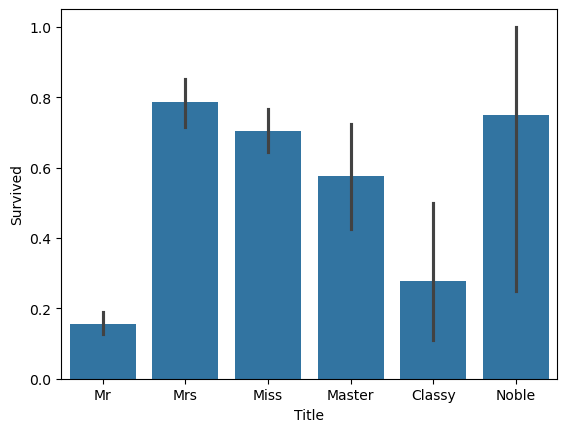

In [12]:
sns.barplot(x="Title", y="Survived", data=train_data)
plt.show()

In [13]:
for dataset in combine:
    dataset.loc[(dataset["Title"] == 'Mr'), 'Title'] = 0
    dataset.loc[(dataset["Title"] == 'Mrs'), 'Title'] = 1
    dataset.loc[(dataset["Title"] == 'Miss'), 'Title'] = 2
    dataset.loc[(dataset["Title"] == 'Master'), 'Title'] = 3
    dataset.loc[(dataset["Title"] == 'Classy'), 'Title'] = 4
    dataset.loc[(dataset["Title"] == 'Noble'), 'Title'] = 5

train_data = train_data.drop('Name', axis = 1)
test_data = test_data.drop('Name', axis = 1)

train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,7.2500,NaN,S,0
1,2,1,1,1,38.0,1,0,71.2833,C85,C,1
2,3,1,3,1,26.0,0,0,7.9250,NaN,S,2
3,4,1,1,1,35.0,1,0,53.1000,C123,S,1
4,5,0,3,0,35.0,0,0,8.0500,NaN,S,0


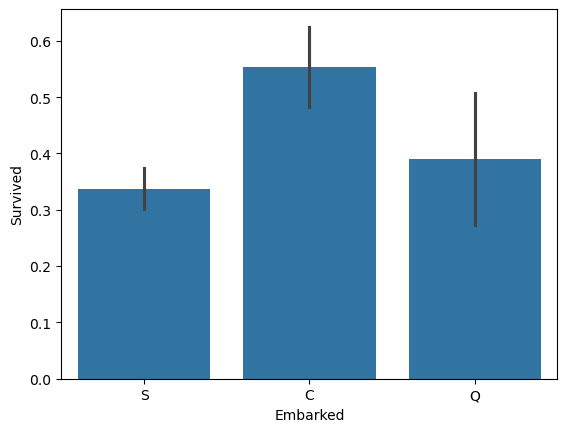

In [14]:
sns.barplot(x="Embarked", y="Survived", data=train_data)
plt.show()


On the surface these seems like a perfectly valid and unique source of information. However if you look closer you wiil see that this category is derivative of another.

In [15]:
pclass_proportions = train_data.groupby('Embarked')['Pclass'].value_counts(normalize=True)

# Display the results
print(pclass_proportions.sort_index())

Embarked  Pclass
C         1         0.505952
          2         0.101190
          3         0.392857
Q         1         0.025974
          2         0.038961
          3         0.935065
S         1         0.197205
          2         0.254658
          3         0.548137
Name: proportion, dtype: float64


As shown above, Embarked is a derivative of Pclass with C only having a higher correlation with survival because it has a larger proportion of first class passengers. Therefore we should get rid of Embarked and rely solely on Pclass.

In [16]:
train_data = train_data.drop('Embarked', axis = 1)
test_data = test_data.drop('Embarked', axis = 1)

train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Title
0,1,0,3,0,22.0,1,0,7.2500,NaN,0
1,2,1,1,1,38.0,1,0,71.2833,C85,1
2,3,1,3,1,26.0,0,0,7.9250,NaN,2
3,4,1,1,1,35.0,1,0,53.1000,C123,1
4,5,0,3,0,35.0,0,0,8.0500,NaN,0


Before we can examine Age we have to fix the NaN values present. Age has only 177 NaN values or 13% of the total rows so throwing out the whole set of Data is a waste. Instead we will plug these holes by approximating each missing age.

In [17]:
title_sex_pclass_age_mean = train_data.groupby(['Title', 'Sex', 'Pclass'])['Age'].median()


def fill_age(row):
    if pd.isna(row['Age']):  #
        return title_sex_pclass_age_mean.get((row['Title'], row['Sex'], row['Pclass']), row['Age'])
    else:
        return row['Age']  

train_data['Age'] = train_data.apply(fill_age, axis=1)

test_data['Age'] = train_data.apply(fill_age, axis=1)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Cabin        204 non-null    object 
 9   Title        891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


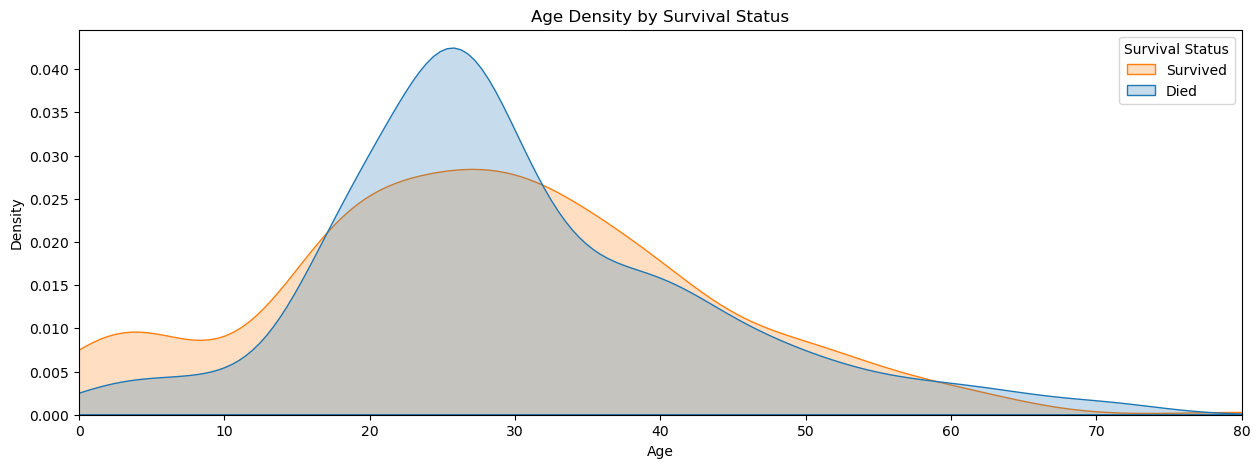

In [18]:
df = pd.DataFrame({'Age':train_data['Age'],'Survival':train_data['Survived']})

plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x='Age', hue='Survival', common_norm=False, fill=True)
plt.title('Age Density by Survival Status')
plt.xlim(left=0)
plt.xlim(right=80)
plt.xlabel('Age')
plt.legend(title="Survival Status", labels=['Survived', 'Died'], loc='upper right')
plt.ylabel('Density')
plt.show()

There are 3 main agegroups where Age affects survival. The biggest one is for passengers below the age of around 12 where you have a higher chance of survival. Then between 12 and 32 you have a higher chance of death. Finally for those ages 60+ you are more likely to die. To make the model more accurate at deciding the chance of death we will change the age variable into 6 age sections. 0 to 8, 8 to 36, 36 to 48, 48 to 63, and 63+.

In [19]:
train_data.loc[(train_data["Age"] <= 8), 'Age'] = 0
train_data.loc[(train_data["Age"] > 8) & (train_data['Age'] <= 36), 'Age'] = 1
train_data.loc[(train_data["Age"] > 36) & (train_data['Age'] <= 48), 'Age'] = 2
train_data.loc[(train_data["Age"] > 48) & (train_data['Age'] <= 63), 'Age'] = 3
train_data.loc[(train_data["Age"] > 63), 'Age'] = 4

test_data.loc[(test_data["Age"] <= 8), 'Age'] = 0
test_data.loc[(test_data["Age"] > 8) & (test_data['Age'] <= 36), 'Age'] = 1
test_data.loc[(test_data["Age"] > 36) & (test_data['Age'] <= 48), 'Age'] = 2
test_data.loc[(test_data["Age"] > 48) & (test_data['Age'] <= 63), 'Age'] = 3
test_data.loc[(test_data["Age"] > 63), 'Age'] = 4

#train_data.head()

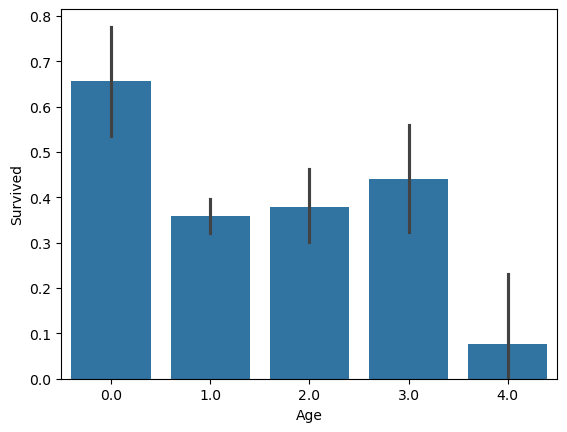

In [20]:
sns.barplot(x="Age", y="Survived", data=train_data)
plt.show()


In [21]:
survived = train_data[train_data['Survived']==1]['Age'].value_counts()
dead = train_data[train_data['Survived']==0]['Age'].value_counts()
print((survived/(survived+dead)).sort_index())


Age
0.0    0.655172
1.0    0.359606
2.0    0.377622
3.0    0.441176
4.0    0.076923
Name: count, dtype: float64


Seeing 

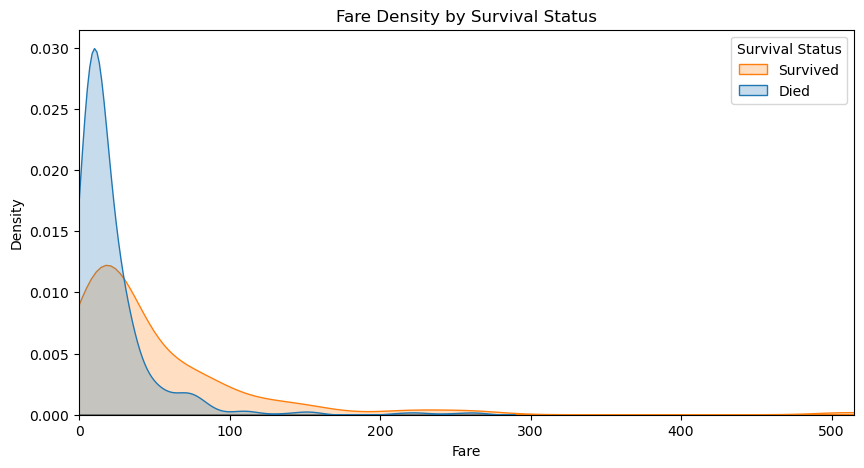

In [22]:
df = pd.DataFrame({'Fare':train_data['Fare'],'Survival':train_data['Survived']})

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Fare', hue='Survival', common_norm=False, fill=True)
plt.xlim(left=0)
plt.xlim(right=515)
plt.title('Fare Density by Survival Status')
plt.xlabel('Fare')
plt.legend(title="Survival Status", labels=['Survived', 'Died'], loc='upper right')
plt.ylabel('Density')
plt.show()

Fare price has a very strong impact on survival rate as anyone paying more than around 50 has a higher chance of surving than dying. And anypne paying below 50 has a massivly higher chance of dying. Additionally anyone paying over 290 has a 100% chance of survival. Lets split up Fare into sections as well. 0 to 25, 25 to 200, 30 to 290 and, 290+.

In [23]:
train_data.loc[(train_data["Fare"] <= 25), 'Fare'] = 0
train_data.loc[(train_data["Fare"] > 25) & (train_data['Fare'] <= 200), 'Fare'] = 1
train_data.loc[(train_data["Fare"] > 200) & (train_data['Fare'] <= 290), 'Fare'] = 2
train_data.loc[(train_data["Fare"] > 290), 'Fare'] = 3

test_data.loc[(test_data["Fare"] <= 25), 'Fare'] = 0
test_data.loc[(test_data["Fare"] > 25) & (test_data['Fare'] <= 200), 'Fare'] = 1
test_data.loc[(test_data["Fare"] > 200) & (test_data['Fare'] <= 290), 'Fare'] = 2
test_data.loc[(test_data["Fare"] > 290), 'Fare'] = 3


train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Title
0,1,0,3,0,1.0,1,0,0.0,NaN,0
1,2,1,1,1,2.0,1,0,1.0,C85,1
2,3,1,3,1,1.0,0,0,0.0,NaN,2
3,4,1,1,1,1.0,1,0,1.0,C123,1
4,5,0,3,0,1.0,0,0,0.0,NaN,0


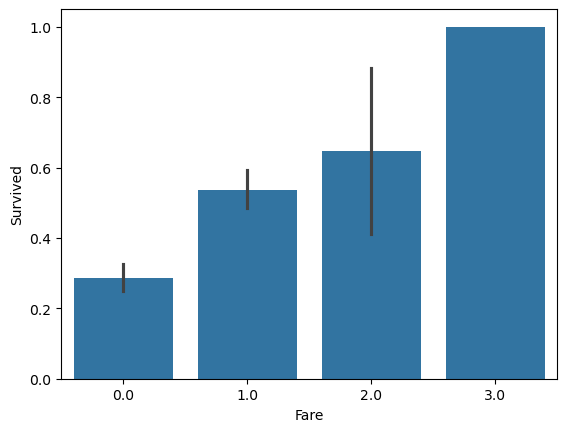

In [24]:
sns.barplot(x="Fare", y="Survived", data=train_data)
plt.show()

In [25]:
title_sex_pclass_fare_mean = train_data.groupby(['Title', 'Sex', 'Pclass'])['Fare'].median()

def fill_age(row):
    if pd.isna(row['Fare']):  #
        return title_sex_pclass_fare_mean.get((row['Title'], row['Sex'], row['Pclass']), row['Fare'])
    else:
        return row['Fare']  # If Age is not NaN, keep the original value

train_data['Fare'] = train_data.apply(fill_age, axis=1)

test_data['Fare'] = train_data.apply(fill_age, axis=1)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Cabin        91 non-null     object 
 8   Title        418 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


Finally is Cabin. Cabin is an interesting case as it has so many NaNs the remaing data is not enough to make assumptions about how each type of cabin affects survival. However, perhaps the very fact that someone was known to have a specifc cabin is a clue to their survival.

([<matplotlib.axis.XTick at 0x14cac99d0>,
 [Text(0, 0, 'No Cabin'), Text(1, 0, 'Known Cabin')])

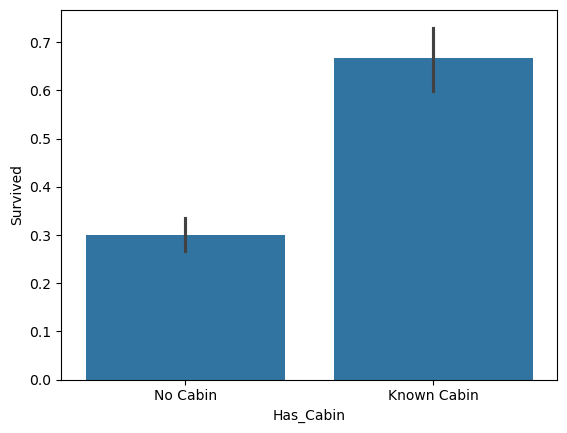

In [26]:
train_data['Has_Cabin'] = train_data['Cabin'].notna().astype(int)
test_data['Has_Cabin'] = train_data['Cabin'].notna().astype(int)

sns.barplot(x="Has_Cabin", y="Survived", data=train_data)
plt.xticks([0, 1], ['No Cabin', 'Known Cabin'])


As shown in this graph, people with a cabin have a much higher survival rate than those without a known cabins.

In [27]:
train_data = train_data.drop('Cabin', axis = 1)
test_data = test_data.drop('Cabin', axis = 1)

train_data.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Has_Cabin
0,1,0,3,0,1.0,1,0,0.0,0,0
1,2,1,1,1,2.0,1,0,1.0,1,1
2,3,1,3,1,1.0,0,0,0.0,2,0
3,4,1,1,1,1.0,1,0,1.0,1,1
4,5,0,3,0,1.0,0,0,0.0,0,0


Now we have our finalized data and so it is time to decide what goes into the model and what does not. First of all it would be wise to remove 'Sex'. This is because 'Title' serves the same role as a separator of 'Sex' and having 2 features clashing over the same category will just make the model worse.

In [28]:
from sklearn.model_selection import train_test_split

#'Survived', 'PassengerId','Embarked','Fare','Sex',"Pclass" ,"Age","SibSp", "Parch","Has_Cabin"
predictors = train_data.drop(['Survived', 'PassengerId',"Sex"], axis=1)
target = train_data["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 1)

In [29]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(x_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to view feature importance
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

     Feature  Importance
5      Title    0.462343
0     Pclass    0.126872
1        Age    0.105676
2      SibSp    0.091503
6  Has_Cabin    0.082354
4       Fare    0.067437
3      Parch    0.063815


Judging by this importance chart the only 2 features that are worth keeping around are Titles and Pclass. 

In [30]:
from sklearn.metrics import accuracy_score

predictors = train_data.drop(['Survived', 'PassengerId','Fare','Sex' ,'Age','SibSp', 'Parch','Has_Cabin'], axis=1)
target = train_data["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.4, random_state = 1)

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

76.47


The predicted accuracy is 76.47%.

In [31]:
y = train_data["Survived"]

features = ["Pclass","Title",]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('Predictions.csv', index=False)


The actual accuracy is 79.45%.